<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-gwkcareer/blob/main/week1/1_3_MNIST(%EA%B8%B0%EB%B3%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 기본과제

28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제

library import

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

dataset은 `torchvision`에서 다운로드
- train 데이터
- test 데이터



> PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며,
 `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.


In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


전체 data의 개수와 첫 번째 data를 출력하여 확인




60000
torch.Size([1, 28, 28]) 5


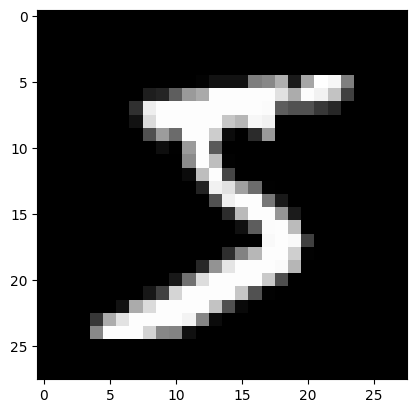

In [ ]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현

testdata 는 shuffle = False

> 학습 과정에서는 shuffle=True를 사용하여 데이터를 무작위로 섞어 데이터의 편향을 줄이고, 모델이 다양한 패턴을 학습하도록 돕습니다.반면, 테스트 과정에서는 데이터 순서에 영향을 받지 않고 평가하는 것이 중요하므로, 데이터를 섞지 않고 고정된 순서로 평가합니다.


In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.



위에서 batch size를 256로 설정했기 때문에 총 256개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


3-layer MLP를 구현


> 이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.



In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 출력 레이어 변경

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # x = self.act(self.layer3(x))
    x = self.layer3(x)                # Logits without activation

    return x


model = Model(28 * 28 * 1, 1024)


 gradient descent를 수행해줄 optimizer를 구현하는 모습


> `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.




In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

정확도 측정 함수


In [ ]:
# model 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

정확도 시각화

In [ ]:
# model 정확도 시각화
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

model을 MNIST에 학습

Epoch   0 | Loss: 539.3524963855743
Epoch   1 | Loss: 535.6638433933258
Epoch   2 | Loss: 531.8435266017914
Epoch   3 | Loss: 527.7824697494507
Epoch   4 | Loss: 523.3551795482635
Epoch   5 | Loss: 518.4672064781189
Epoch   6 | Loss: 512.9856615066528
Epoch   7 | Loss: 506.732209444046
Epoch   8 | Loss: 499.6143145561218
Epoch   9 | Loss: 491.3985195159912
Epoch  10 | Loss: 481.9395365715027
Epoch  11 | Loss: 471.0305737257004
Epoch  12 | Loss: 458.58872747421265
Epoch  13 | Loss: 444.448340177536
Epoch  14 | Loss: 428.5153533220291
Epoch  15 | Loss: 411.02055513858795
Epoch  16 | Loss: 392.10396921634674
Epoch  17 | Loss: 372.19946897029877
Epoch  18 | Loss: 351.72375202178955
Epoch  19 | Loss: 331.3831367492676
Epoch  20 | Loss: 311.6580001115799
Epoch  21 | Loss: 292.99091851711273
Epoch  22 | Loss: 275.67385160923004
Epoch  23 | Loss: 259.8654496073723
Epoch  24 | Loss: 245.58655393123627
Epoch  25 | Loss: 232.69190388917923
Epoch  26 | Loss: 221.24805092811584
Epoch  27 | Loss: 21

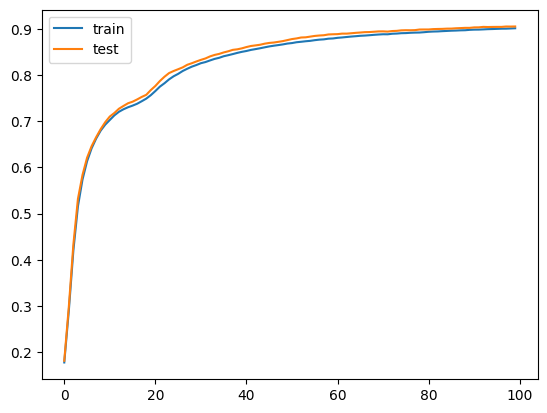

In [ ]:
n_epochs = 100

# 손실 함수 정의 - CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 정확도 저장을 위한 리스트
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 모델 예측
    preds = model(inputs)

    # 손실함수 계산 - MSE
    #loss = (preds[:, 0] - labels).pow(2).mean()
    #loss.backward()
    #optimizer.step()

    # 손실함수 계산 - CrossEntropyLoss
    # CrossEntropyLoss는 labels가 [batch_size] 형태여야 합니다.
    loss = criterion(preds, labels)  # preds: [batch_size, num_classes], labels: [batch_size]
    loss.backward()
    optimizer.step()

    total_loss += loss.item()


  train_accuracy = accuracy(model, trainloader)
  test_accuracy = accuracy(model, testloader)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

# 정확도 플로팅
plot_acc(train_accuracies, test_accuracies)